In [6]:
import numpy as np
from scipy.optimize import minimize
from groo.groo import get_root
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from groo.groo import get_root
rf = get_root(".hidden_root_mc")
sys.path.append(os.path.join(rf))

from models_and_funcs import *
import itertools as it 

In [197]:
# Generate data 



# Make choices
N = 180
# Generate data 
rewards, repeated_df = gen_bandits(N, nbandit=3)
indata = {"options": repeated_df, "r":rewards, "nbandit":3, "model":rw6_val_choice, "generate_choices":1} 
# make choices
m = rw6_val_choice([0.2,0.2, 0.2, 0.8,0.8, 0.8, 2], indata)
indata["choices"] = m["choices"]
indata["generate_choices"] = 0
print(lklhd_choice([0.2,0.2, 0.2, 0.8,0.7, 0.8, 2], indata))
print(lklhd_choice([0.2,0.2, 0.2, 0.8,0.8, 0.8, 2], indata))

m1=lklhd_choice_m([0.2,0.2, 0.2, 0.8,0.6, 0.8, 2], indata)
print(m1["acc"])
m2=lklhd_choice_m([0.2,0.2, 0.2, 0.8,0.8, 0.8, 1], indata)
print(m2["acc"])

17.27974447892501
16.875692608773097
0.9666666666666667
0.9222222222222223


In [98]:
bnds = ((0,1),(0.0001,50))
#bnds = ((0,100),(0,1),(0,1))
opt = minimize(fun=lklhd_choice, x0=[0.2, 5], args=(indata), method='Nelder-Mead', bounds=bnds, options={'verbose': 0})
print(opt.message)
print(opt.x)

/tmp/ipykernel_370341/3250818362.py:3: OptimizeWarning: Unknown solver options: verbose
  opt = minimize(fun=lklhd_choice, x0=[0.2, 5], args=(indata), method='Nelder-Mead', bounds=bnds, options={'verbose': 0})


Maximum number of function evaluations has been exceeded.
[0.19608551 5.12440556]


In [171]:
rewards[178:,:]

array([[18.57149425, 17.61402364, 82.02045283],
       [20.57788344, 20.30166931, 83.23943877]])

In [181]:
vals = np.array([0.3, np.nan])
if any(np.isnan(vals)) | any(np.isinf(vals)):
    stop= 1
np.isin

True

### test model runs

In [1]:

cond = "test"
alg = "COBYLA"
choice_noise = 0.2
value_noise=10
c = 60
iterations = 5
cond_str = "mc_n"+str(noise)+"_c"+str(c)+"_i"+str(iterations)+"_"+alg

import numpy as np
from scipy.optimize import minimize
from groo.groo import get_root
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from groo.groo import get_root
rf = get_root(".hidden_root_mc")
sys.path.append(os.path.join(rf))

from models_and_funcs import *

N = 180
#noise_level= [5, 10, 20]
#cutoff = [90, 120, 150]
models = [rw1_choice, rw2_val_choice, rw3_choice, rw6_val_choice] 
model_names = ["rw1_choice", "rw2_val_choice", "rw3_choice", "rw6_val_choice"]
bounds = {"rw1_choice": ((0,1),(0.001,50)),
          "rw2_val_choice": ((0,1),(0,1),(0.001,50)), 
          "rw3_choice": ((0,1),(0,1),(0,1),(0.001,50)), 
          "rw6_val_choice": ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0.001,50))}
df = pd.DataFrame()


for ii in range(iterations):
    print(np.round(ii/iterations,2))
    # Generate data
    rew_all, options_all = gen_bandits(N, nbandit=3, noise=value_noise)
    #indata = {"options": repeated_df, "r":rewards, "nbandit":3, "model":rw6_val_choice, "generate_choices":1} 

    # trainign data 
    rw_train = rew_all[0:c,:]
    op_train = options_all.iloc[0:c, :]

    # testing data 
    rw_test = rew_all[c:,:]
    op_test = options_all.iloc[c:, :]

    for m_idx, (m, mname) in enumerate(zip(models, model_names)): # loop over model GENERATING the data
        params_in = gen_rand_vals(bounds[mname])
        indata = {"options": options_all, "r":rew_all, "nbandit":3, "model":m, "generate_choices":1} 

        mpred = m(params_in, indata)

        #induce noice by randomly replaceing proportion of choices
        mpred["choices"] = replace_random_values(mpred["choices"], indata["options"], choice_noise)

        ch_train = mpred["choices"][0:c]
        ch_test = mpred["choices"][c:]

        # Fit data 
        AIC =[] 
        BIC = []
        AICc = [] 
        HQC = [] #https://en.wikipedia.org/wiki/Hannan%E2%80%93Quinn_information_criterion
        P = {}
        for mfit, mname_fit in zip(models, model_names):
            # prepare data generated above for fit - all trainingn    
            indata = {"options": op_train, "r":rw_train, "nbandit":3, "model":mfit, "generate_choices":0, "choices":ch_train, "get_acc": 0} 

            # fit
            opt = minimize(fun=lklhd_choice, x0=gen_rand_vals(bounds[mname_fit]), args=(indata), method=alg, bounds=bounds[mname_fit], options={'verbose': 0})

            # Get IC 
            M = lklhd_choice_m(opt.x, indata)

            AIC.append(M["AIC"])
            BIC.append(M["BIC"])
            AICc.append(M["AICc"])
            HQC.append(M["HQC"])
            P[mname_fit] = opt.x
        
        # which model fit best
        best_idx =[np.argmin(AIC), np.argmin(AICc), np.argmin(BIC), np.argmin(HQC)]
        # is this the correct model
        #if aic_idx == m_idx:
        #    m_recovery_AIC = 1 # etc

        # get predictive error per trial of the best model
        acc = []
        for idxx, best in enumerate(best_idx):
            #test all 
            indata = {"options": op_test, "r":rw_test, "nbandit":3, "model":models[best_idx[idxx]], "generate_choices":0, "choices":ch_test, "get_acc": 1} 
            Mbest = lklhd_choice_m(P[model_names[best_idx[idxx]]], indata)
            acc.append(Mbest["acc"])

        # Gather data
        D = {"value_noise": value_noise, "choice_noise": choice_noise, "cutoff":c, "true_model": mname, "algo":alg,
            "best_model_AIC": model_names[best_idx[0]], 
            "best_model_AICc": model_names[best_idx[1]],  
            "best_model_BIC": model_names[best_idx[2]], 
            "best_model_HQC": model_names[best_idx[3]], 
            "acc_AIC": acc[0],
            "acc_AICc": acc[1],
            "acc_BIC": acc[2], 
            "acc_HQC": acc[3]                  
            }
        dfrow = pd.DataFrame.from_dict(D, orient="index").T
        df = pd.concat([df, dfrow], axis=0)
df.to_csv(os.path.join(rf, "data", cond, "model_comparison_iter"+cond_str+".csv") )

0.0


/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bou

KeyboardInterrupt: 

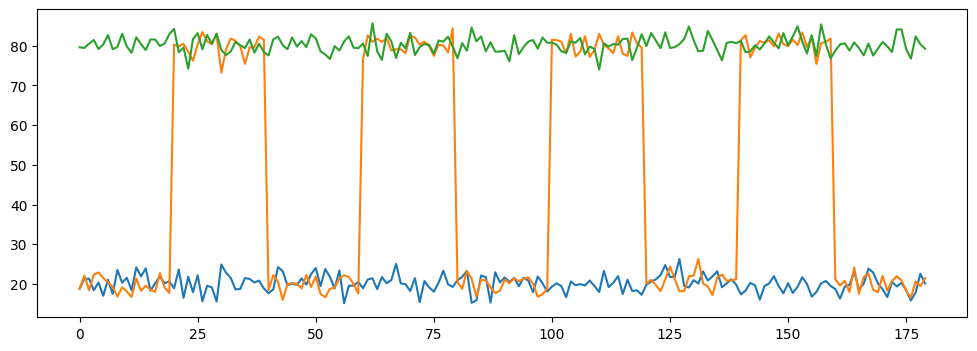

In [275]:
f, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(rew_all)

### compare how different are model predictions

In [254]:
chdf =  pd.DataFrame()
N=180
iterations = 20

for ii in range(iterations):
    print(np.round(ii/iterations,2))
    # Generate data
    rew_all, options_all = gen_bandits(N, nbandit=3)
    #indata = {"options": repeated_df, "r":rewards, "nbandit":3, "model":rw6_val_choice, "generate_choices":1} 

    for m_idx, (m, mname) in enumerate(zip(models, model_names)): # loop over model GENERATING the data
        params_in = gen_rand_vals(bounds[mname])
        indata = {"options": options_all, "r":rew_all, "nbandit":3, "model":m, "generate_choices":1} 

        mpred = m(params_in, indata)
        chdf = pd.concat([chdf, pd.DataFrame({"dataset_id":ii,"choices": mpred["choices"].astype(int), "model": mname, "noise":noise, "noise_included": False})])

        #induce noice by randomly replaceing proportion of choices
        for noise in [0, 0.2, 0.5, 0.8]:
            mpred["choices"] = replace_random_values(mpred["choices"], indata["options"], noise)
            chdf = pd.concat([chdf, pd.DataFrame({"dataset_id":ii,"choices": mpred["choices"].astype(int), "model": mname, "noise":str(noise), "noise_included": True})])

chdf.to_csv(os.path.join(rf, "data", "choices_simulated.csv"))

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


In [256]:
chdf["trial"] = chdf.index

In [257]:

chdf2 = chdf.loc[chdf["noise_included"]==True,].pivot(values=["choices"], index=["dataset_id", "trial"], columns=["model", "noise"]).reset_index()

In [264]:
import seaborn as sns 
cdf = chdf2.corr().reset_index()
cdf.columns = [' '.join(col).strip() for col in cdf.columns.values]
cdf = cdf.loc[cdf["level_0"]=="choices", ] 
cdf["joint_y"] = cdf["model"] + cdf["noise"]
cdf = cdf.drop(columns=["level_0", "model", "noise", "dataset_id", "trial"]).set_index("joint_y")


<AxesSubplot: ylabel='joint_y'>

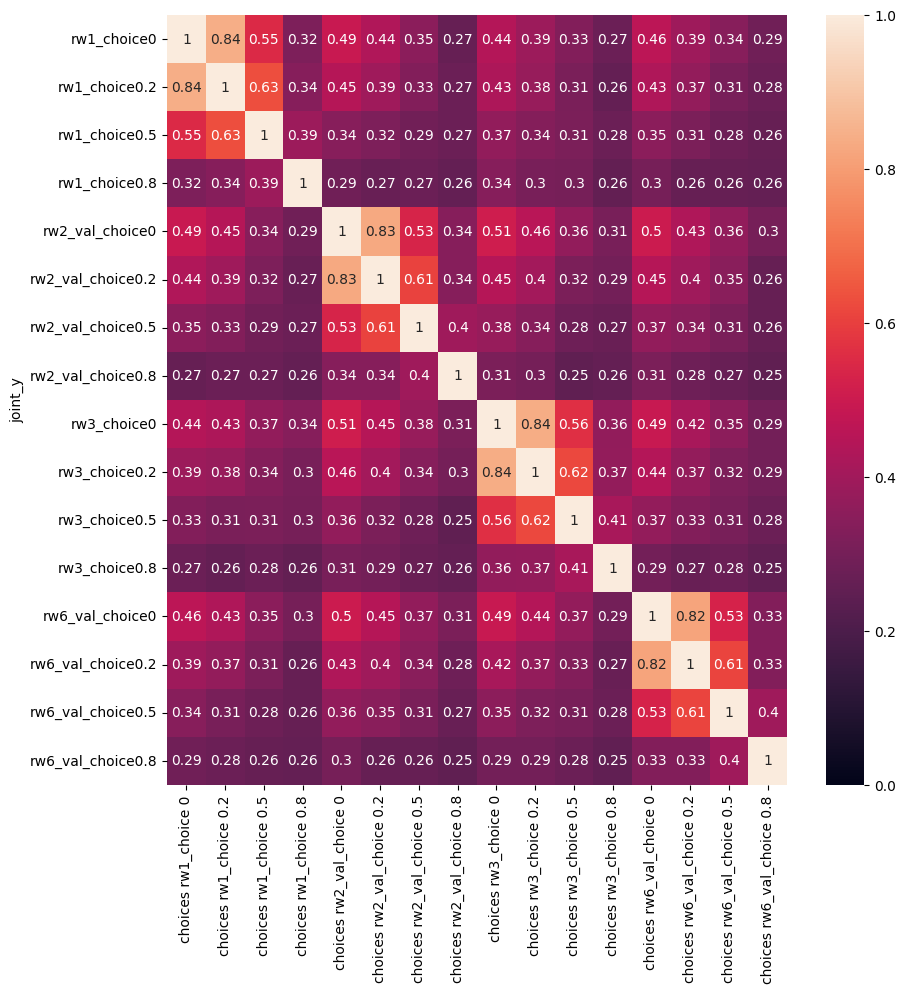

In [270]:
f,ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(cdf, vmin=0, vmax=1, annot=True, ax=ax)